In [1]:
#imports
import pandas as pd
from sklearn.preprocessing import LabelEncoder ,  StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix , f1_score
# Install required libraries
!pip install lime shap scikit-learn numpy pandas matplotlib tensorflow pillow
# Note: After installation, restart the runtime to ensure all libraries are properly loaded.
!pip install lime
import shap
import warnings
warnings.filterwarnings("ignore")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9067a68bdca245bec5884102a80e5ce6ad55f03311eda8aea4f061185951985e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')


In [3]:
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

In [4]:
import pandas as pd
import numpy as np

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()

drop_cols = [col for col in train.columns if train[col].isnull().mean() > 0.90]
print("Dropping these columns due to too many missing values:", drop_cols)
train.drop(columns=drop_cols, inplace=True)

#Fill missing values in categorical columns with mode
for col in categorical_cols:
    if col in train.columns and train[col].isnull().sum() > 0:
        mode_val = train[col].mode()[0]
        train[col] = train[col].fillna(mode_val)

#Fill missing values in numerical columns with mean
for col in numerical_cols:
    if col in train.columns and train[col].isnull().sum() > 0:
        mean_val = train[col].mean()
        train[col] = train[col].fillna(mean_val)

#In case any values remain
train = train.fillna("unknown")

# Final check
print("Missing values after processing:")
print(train.isnull().sum().sum(), "missing values remaining.")


Dropping these columns due to too many missing values: ['dist2', 'D7', 'D12', 'D13', 'D14', 'id_03', 'id_04', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
Missing values after processing:
0 missing values remaining.


In [5]:
categorical_cols = test.select_dtypes(include=['object']).columns.tolist()
numerical_cols = test.select_dtypes(include=[np.number]).columns.tolist()

drop_cols = [col for col in test.columns if test[col].isnull().mean() > 0.90]
print("Dropping these columns due to too many missing values:", drop_cols)
test.drop(columns=drop_cols, inplace=True)

for col in categorical_cols:
    if col in test.columns and test[col].isnull().sum() > 0:
        mode_val = test[col].mode()[0]
        test[col] = test[col].fillna(mode_val)


for col in numerical_cols:
    if col in test.columns and test[col].isnull().sum() > 0:
        mean_val = test[col].mean()
        test[col] = test[col].fillna(mean_val)


test = test.fillna("unknown")


print("Missing values after processing:")
print(test.isnull().sum().sum(), "missing values remaining.")


Dropping these columns due to too many missing values: ['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 'id-03', 'id-04', 'id-07', 'id-08', 'id-09', 'id-10', 'id-14', 'id-18', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-30', 'id-32', 'id-33', 'id-34']
Missing values after processing:
0 missing values remaining.


In [6]:
categorical_columns1 = train.select_dtypes(include=['object', 'category']).columns
print("Categorical Columns:", categorical_columns1)

Categorical Columns: Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35',
       'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype='object')


In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns1:
    train[col] = label_encoder.fit_transform(train[col])

target_column = 'isFraud'

numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop(target_column)

scaler = StandardScaler()
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])




In [8]:
X = train.drop(columns=['isFraud', 'TransactionID', 'TransactionDT'], errors='ignore')
y = train['isFraud']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_resampling, y_train_resampling = sm.fit_resample(X_train, y_train)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Create the Decision Tree model
dt_model = DecisionTreeClassifier(criterion='gini',  max_depth=5,random_state=42)


dt_model.fit(X_train_resampling,y_train_resampling)

# 3. Predict on test data
y_pred = dt_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9353099730458221

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       362
           1       0.11      0.22      0.14         9

    accuracy                           0.94       371
   macro avg       0.54      0.59      0.55       371
weighted avg       0.96      0.94      0.95       371


Confusion Matrix:
 [[345  17]
 [  7   2]]


In [12]:
f1 = f1_score(y_test, y_pred)
print(f"F1-score : {f1:.4f}")

F1-score : 0.1429


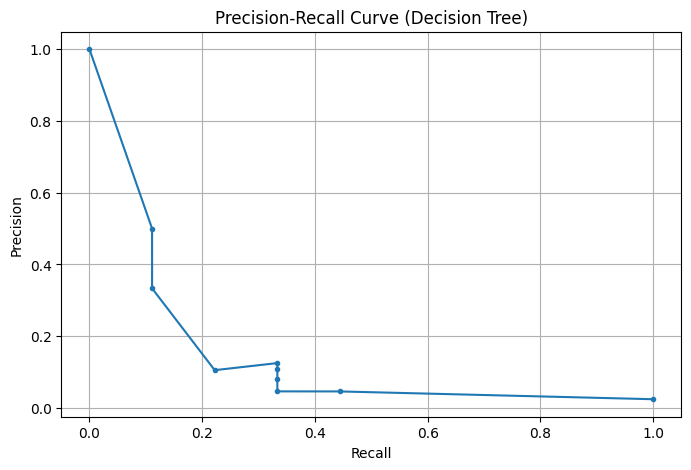

In [43]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


y_probs_dt = dt_model.predict_proba(X_test)[:, 1]


y_pred_adjusted_dt = (y_probs_dt > 0.2).astype(int)

precision, recall, thresholds = precision_recall_curve(y_test, y_probs_dt)

# Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Decision Tree)")
plt.grid(True)
plt.show()


In [14]:
X_train_df =  pd.DataFrame(X_train, columns=train.columns)

PDP

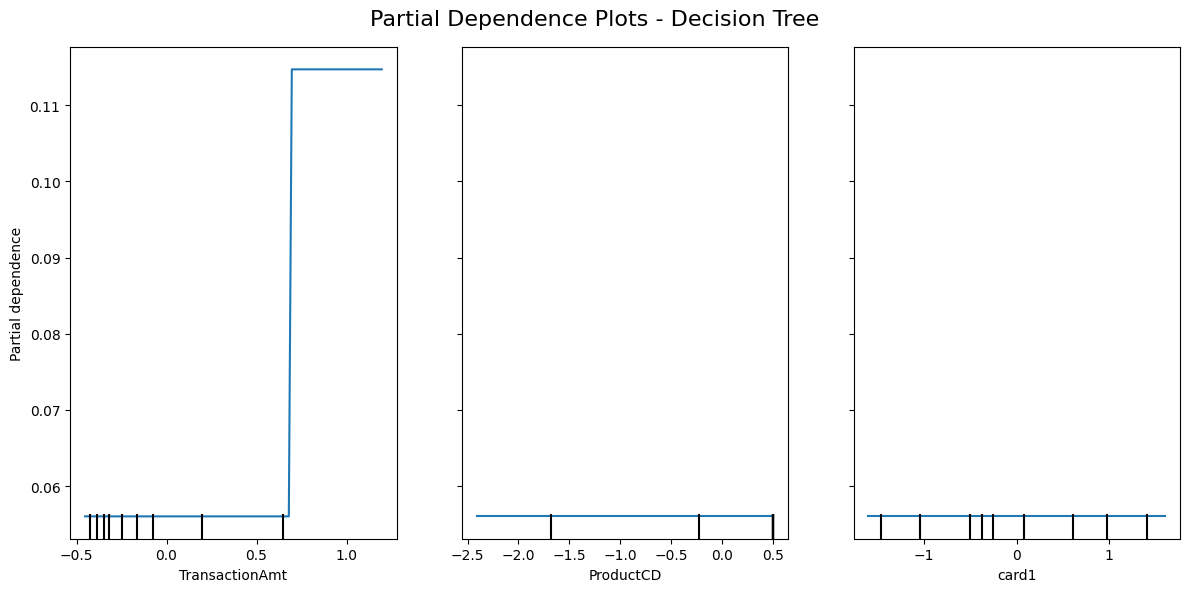

In [26]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = [0, 1, 2]
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(dt_model, X_test, features=features_to_plot, ax=ax)
plt.suptitle("Partial Dependence Plots - Decision Tree", fontsize=16)
plt.tight_layout()
plt.show()


Feature Importance

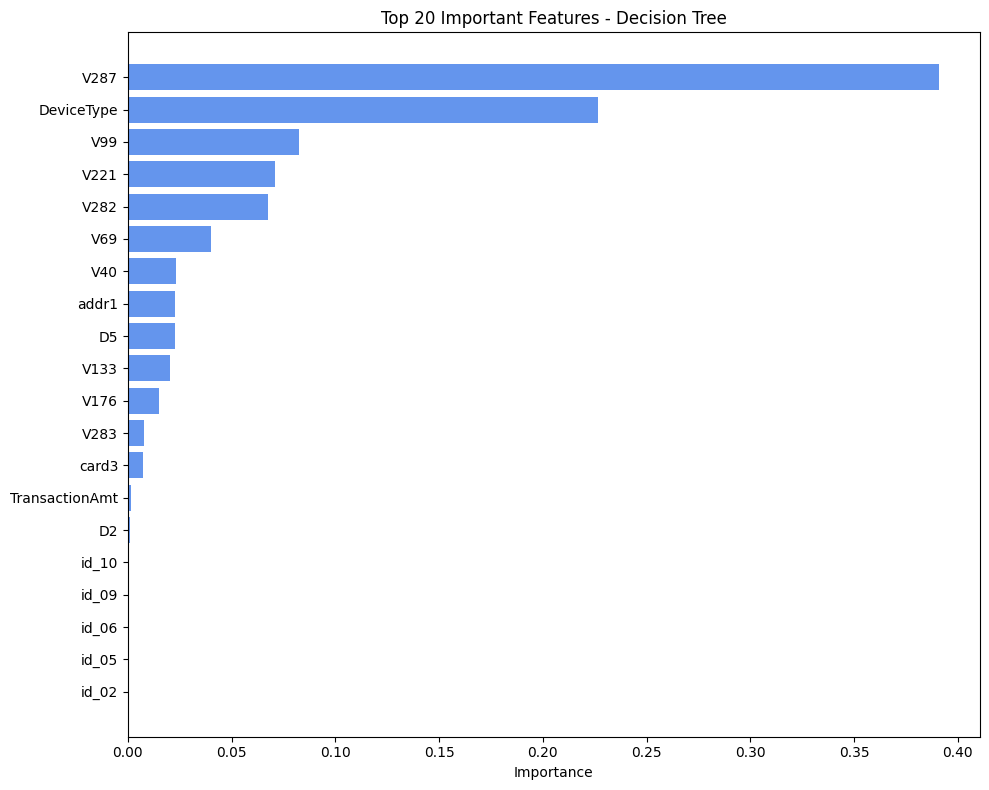

In [27]:
# Sort in descending order to get most important features at the top
top_n = 20
top_features_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='cornflowerblue')
plt.xlabel("Importance")
plt.title(f"Top {top_n} Important Features - Decision Tree")
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()


Tree Visualization

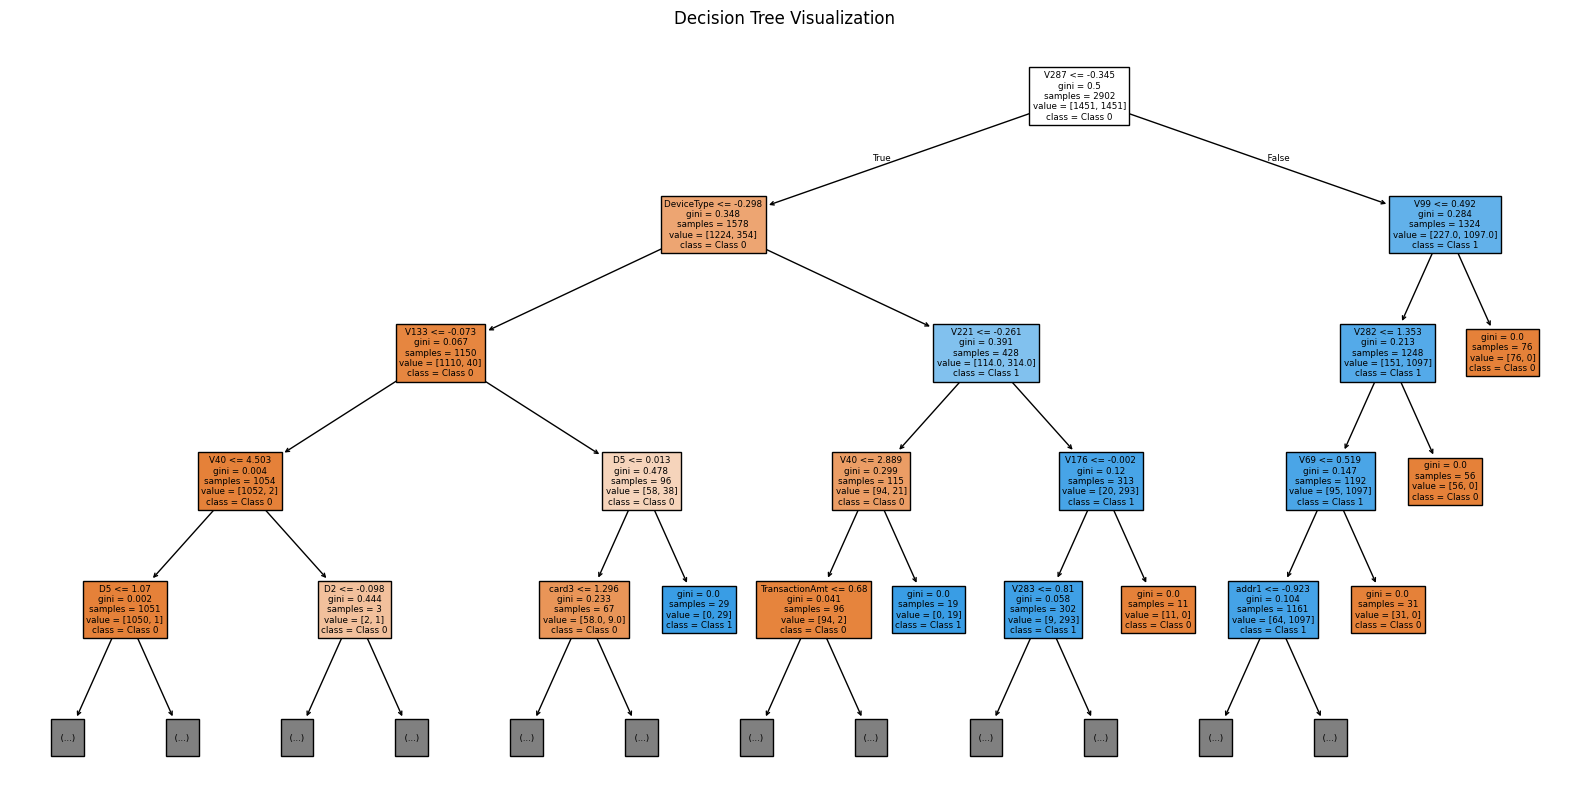

In [28]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, class_names=['Class 0', 'Class 1'], filled=True, max_depth=4)
plt.title("Decision Tree Visualization")
plt.show()


LIME

In [24]:
import lime
import lime.lime_tabular
import numpy as np

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_resampling),
    feature_names=X_train_resampling.columns,
    class_names=['Class 0', 'Class 1'],
    mode='classification'
)

i = 1
exp = explainer.explain_instance(X_test.iloc[i], dt_model.predict_proba)
exp.show_in_notebook(show_all=False)


SHAP

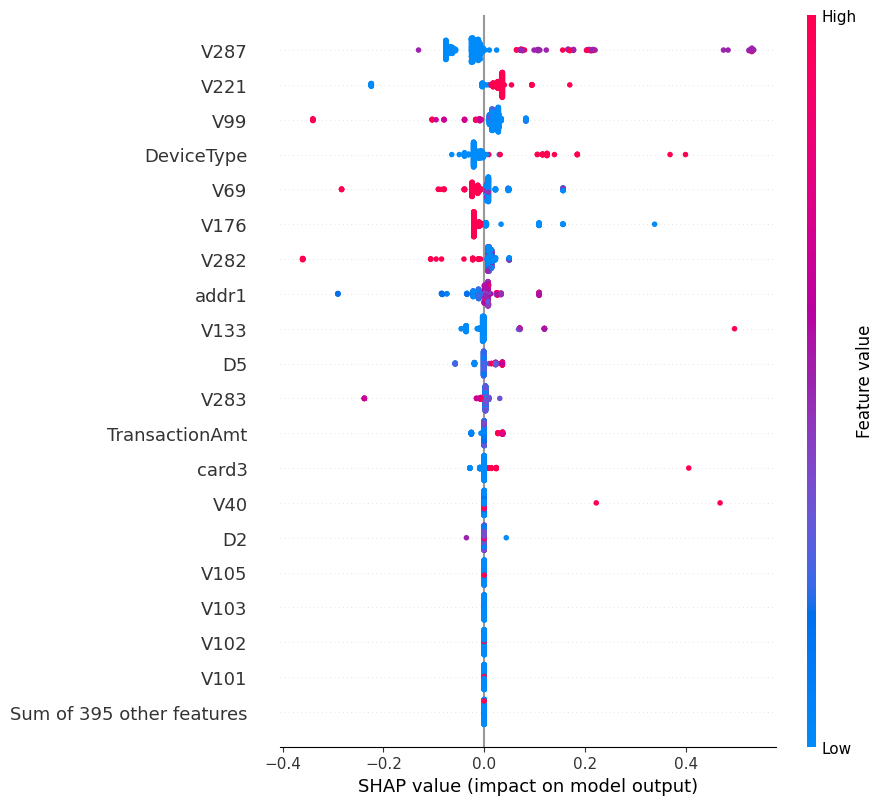

In [39]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(dt_model, X_train)

# Get SHAP values for all classes
shap_values = explainer(X_test)

# Extract SHAP values for class 1
shap_values_class_1 = shap_values[:, :, 1]

# Now plot
shap.plots.beeswarm(shap_values_class_1, max_display=20)


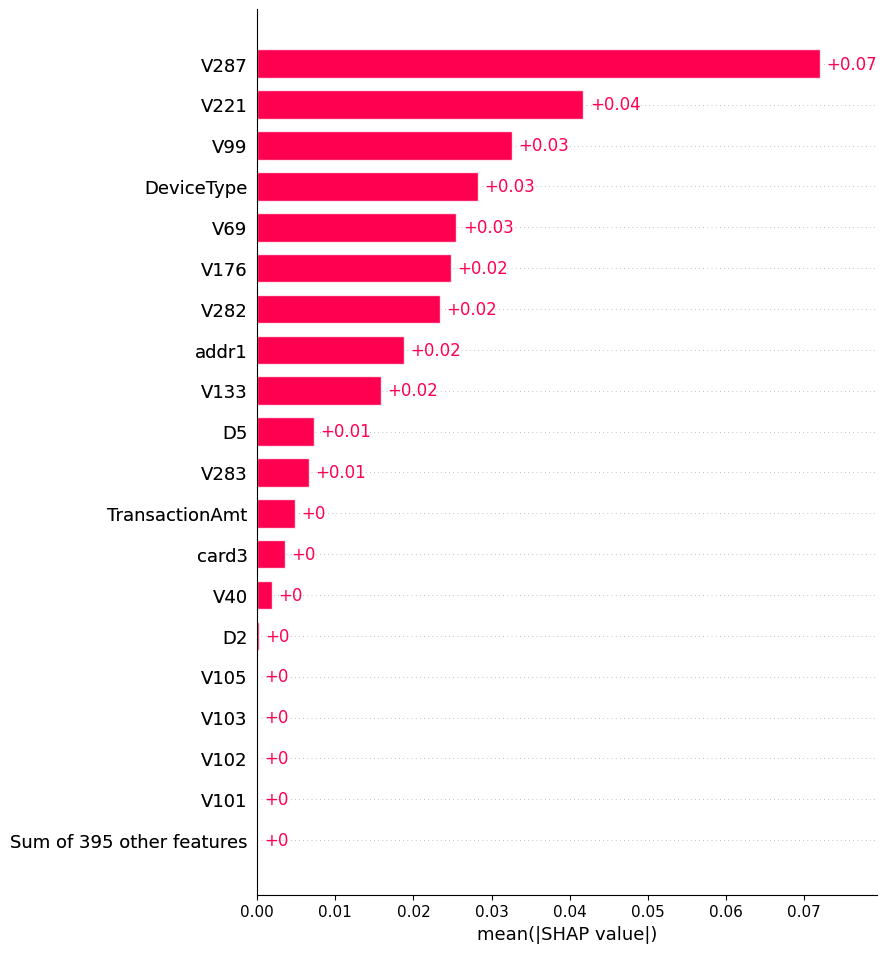

In [40]:
shap.plots.bar(shap_values[:, :, 1], max_display=20)


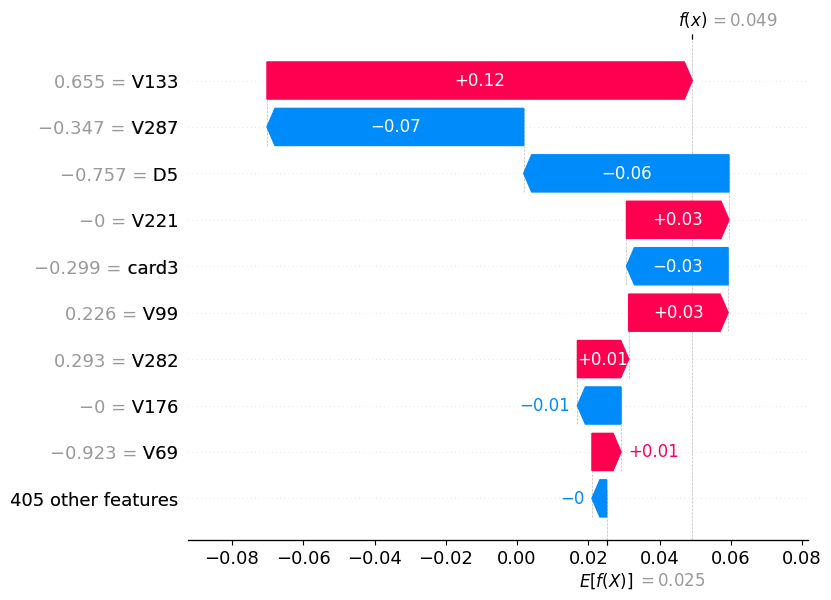

In [41]:
shap.plots.waterfall(shap_values[0, :, 1])
